In [1]:
using Plots


include("distributions.jl")
include("structures.jl")
include("distances/w_distance.jl") # ar mchirdeba? 
include("distances/new_distance.jl")
include("distances/distance_Wasserstein.jl")


ww (generic function with 2 methods)

In [2]:


function sample_distances_thresholds(q_1::PPM, q_2::PPM, n::Int, m::Int, s::Int, θs::Vector{Float64}, n_permutations::Int)
    # This functions samples distances between hierarchical empirical measures and also gets thresholds for each of the distance using permutatoin approach
    
    # q_1 :: Law of random probabiity measure Q^1
    # q_2 :: Law of random probabiity measure Q^2
    # n :: Number of rows in hierarchical sample
    # m :: Number of columns in hierarchical sample
    # s :: Number of distances sampled
    # θs :: Vector of probability levels for thresholds
    # n_permutations :: Number of permutations for permutation approach

    d_wws = Vector{Float64}(undef, s)
    d_lips = Vector{Float64}(undef, s)

    perm_thresholds = zeros(length(θs), s, 2) # first dimension corresponds to probability level θ, second one - generated empirical measure, third one - distance function(WoW or HIPM)

    for i in 1:s
        emp_1, emp_2 = generate_emp(q_1, n, m), generate_emp(q_2, n, m) # Q^1_{n,m}, Q^2_{n,m}
        d_wws[i] = ww(emp_1, emp_2)
        d_lips[i] = dlip(emp_1, emp_2)
        
        # now we get threshold for each distance per each probability level θ. This is different from threshold via Rademacher complexity because here threshold
        # depends on the generated empirical measures.

        # To get threshold we first obtain approximate samples of d(Q^1_{n,m}, Q^2_{n,m}) that we call permuted_samples
        permuted_samples_ww = zeros(n_permutations)
        permuted_samples_dlip = zeros(n_permutations)

        for k in 1:n_permutations
            total_rows = vcat(emp_1.atoms, emp_2.atoms)
            random_indices = randperm(2n) # indices to distribute rows to new hierarchical meausures

            emp_1_permuted = emp_ppm(total_rows[random_indices[1:n],:], n, m, emp_1.a, emp_1.b)
            emp_2_permuted = emp_ppm(total_rows[random_indices[n+1:end],:], n, m, emp_2.a, emp_2.b)

            permuted_samples_ww[k] = ww(emp_1_permuted, emp_2_permuted)
            permuted_samples_dlip[k] = dlip(emp_1_permuted, emp_2_permuted)
        end

        # Now we compute thresholds for each distance function and probability level θ
        perm_thresholds[:, i, 1] = quantile(sqrt(n/2) * permuted_samples_ww, 1 .- θs) # thresholds for WoW
        perm_thresholds[:, i, 2] = quantile(sqrt(n/2) * permuted_samples_dlip, 1 .- θs) # thresholds for HIPM
    end

    return d_wws, d_lips, perm_thresholds
end

sample_distances_thresholds (generic function with 1 method)

In [3]:
function rejection_rate(d_wws::Vector{Float64}, d_lips::Vector{Float64}, perm_thresholds::Array{Float64,3}, θs::Vector{Float64})
    # Given sampled distances and thresholds we compute rejection rates for each distance function and probability level θ

    n = length(d_wws)
    n_θ = length(θs)
    rej_rates = zeros(n_θ, 2) # first column corresponds to WoW, second - dlip. Row corresponds to levels of θs.

    for i in 1:n_θ
        thresh_ww = perm_thresholds[i, :, 1]
        thresh_dlip = perm_thresholds[i, :, 2]

        rej_rates[i, 1] = sum(sqrt(n / 2) * d_wws .> thresh_ww) / n
        rej_rates[i, 2] = sum(sqrt(n / 2) * d_lips .> thresh_dlip) / n
    end

    return rej_rates
end



rejection_rate (generic function with 1 method)

In [4]:

q_discr_1 = discrrpm(10,10,0.0,1.0) 
q_discr_2 = discrrpm(10,10,0.0,1.0)

s = 1 # number of times to sample distances between hierarchical empirical measurse
n = 1 
m = 2
θs = collect(0.0:0.01:1.0) # probability levels for which we get thresholds
n_permutations = 1

t = time()
d_wws, d_lips, perm_thresholds = sample_distances_thresholds(q_discr_1, q_discr_2, n, m, s, θs, n_permutations)
t = time() - t
println("time taken: $t seconds")


time taken: 8.560094118118286 seconds


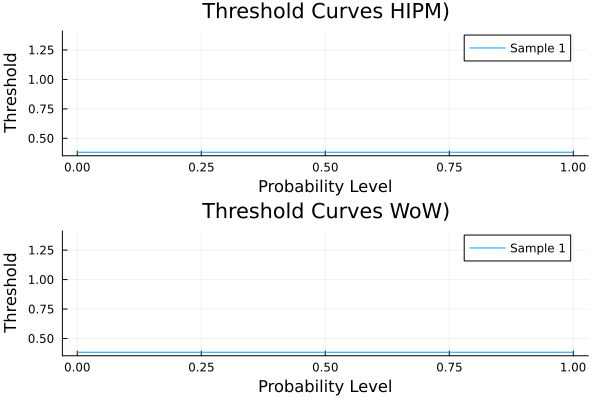

In [5]:

# We are firstly interested if we can avoid using permutation approach exactly as it is defined. In particular, instead of doing permutations per each generated hierarchical
# sample, can we do it only once for one pair of generated hierarchical samples and use the same thresholds for all other generated hierarchical samples?

# let's see if threshold curves differ much for each of the generated hierarchical measures per each distance function.

threshold_curves_dlip = plot()
for i in 1:1
    plot!(threshold_curves_dlip, θs, perm_thresholds[:, i, 2], label="Sample $i", xlabel="Probability Level", ylabel="Threshold", title="Threshold Curves HIPM)")
end

threshold_curves_dww = plot()
for i in 1:1
    plot!(threshold_curves_dww, θs, perm_thresholds[:, i, 1], label="Sample $i", xlabel="Probability Level", ylabel="Threshold", title="Threshold Curves WoW)")
end
# display both plots one below eachother
plot(threshold_curves_dlip, threshold_curves_dww, layout = (2, 1))


# They differ, so it is better to use permutation approach properly.




# Now let's see how much empirical quantile differs from one of the threshold 


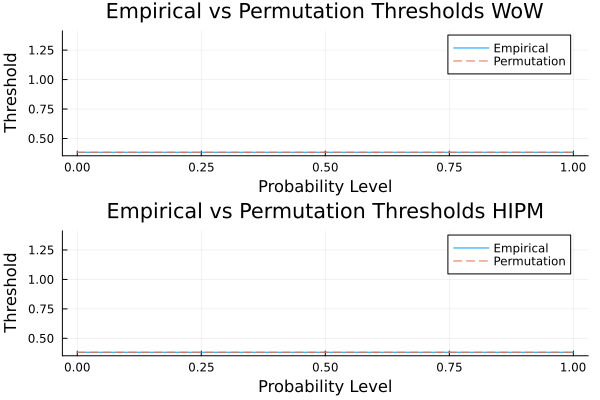

In [6]:


empirical_thresholds_ww = quantile(sqrt(n/2) * d_wws, 1 .- θs)
empirical_thresholds_dlip = quantile(sqrt(n/2) * d_lips, 1 .- θs)

perm_thresh_1_ww = perm_thresholds[:, 1, 1]
perm_thresh_1_dlip = perm_thresholds[:, 1, 2]

emp_vs_perm_thresholds_ww = plot()
plot!(emp_vs_perm_thresholds_ww, θs, empirical_thresholds_ww, label="Empirical", xlabel="Probability Level", ylabel="Threshold", title="Empirical vs Permutation Thresholds WoW")
plot!(emp_vs_perm_thresholds_ww, θs, perm_thresh_1_ww, label="Permutation", linestyle=:dash)

emp_vs_perm_thresholds_dlip = plot()
plot!(emp_vs_perm_thresholds_dlip, θs, empirical_thresholds_dlip, label="Empirical", xlabel="Probability Level", ylabel="Threshold", title="Empirical vs Permutation Thresholds HIPM")
plot!(emp_vs_perm_thresholds_dlip, θs, perm_thresh_1_dlip, label="Permutation", linestyle=:dash)

# display both plots one below eachother
plot(emp_vs_perm_thresholds_ww, emp_vs_perm_thresholds_dlip, layout = (2, 1))


# Now check the rejection rates for each of the distance functions


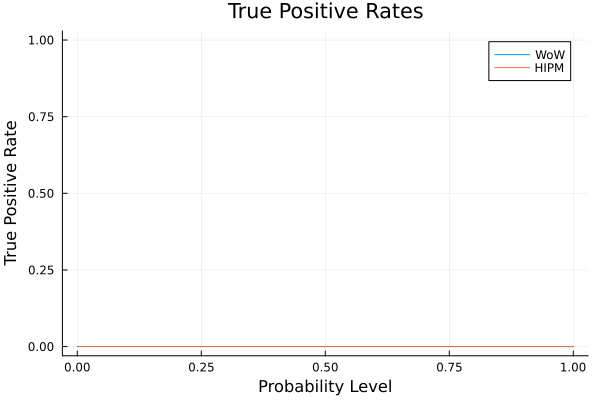

In [7]:

# Now check the rejection rates for each of the distance functions
rej_rates = rejection_rate(d_wws, d_lips, perm_thresholds, θs)

# Let's see the true positive rates
true_positive_plot = plot()
plot!(true_positive_plot, θs, rej_rates[:, 1], label="WoW", xlabel="Probability Level", ylabel="True Positive Rate", title="True Positive Rates")
plot!(true_positive_plot, θs, rej_rates[:, 2], label="HIPM", xlabel="Probability Level", ylabel="True Positive Rate", title="True Positive Rates")

In [8]:
rej_rates

101×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 ⋮    
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

Now let us write a function that given laws of random probability measures and sample sizes, provides plots for empirical threshold vs permutation threshold, and rejection rates. Also for the debug it will return distances and thresholds
  

In [11]:
function simulate_perm(q_1::PPM, q_2::PPM, n::Int, m::Int, s::Int, θs::Vector{Float64}, n_permutations::Int, samemeasures::Bool)
    # q_1 : Law of random probabiity measure Q^1
    # q_2 : Law of random probabiity measure Q^2
    # n : Number of rows in hierarchical sample
    # m : Number of columns in hierarchical sample
    # s : Number of distances sampled
    # θs : Vector of probability levels for thresholds
    # n_permutations : Number of permutations for permutation approach

    #samemeasures : It is true if Q^1 = Q^2 and in that case rejection plot's title is false positive rate, otherwise - true positive rate.
    d_wws, d_lips, perm_thresholds = sample_distances_thresholds(q_discr_1, q_discr_2, n, m, s, θs, n_permutations)

    # now produce thresholds plot ( empirical and threshold from permutation approach)


    empirical_thresholds_ww = quantile(sqrt(n/2) * d_wws, 1 .- θs)
    empirical_thresholds_dlip = quantile(sqrt(n/2) * d_lips, 1 .- θs)

    # recall that perm_threshold has size length(θs, s, 2)
    perm_thresh_1_ww = perm_thresholds[:, 1, 1]
    perm_thresh_1_dlip = perm_thresholds[:, 1, 2]


    emp_vs_perm_thresholds_ww = plot()
    plot!(emp_vs_perm_thresholds_ww, θs, empirical_thresholds_ww, label="Empirical", xlabel="Probability Level", ylabel="Threshold", title="Empirical vs Permutation Thresholds WoW")
    plot!(emp_vs_perm_thresholds_ww, θs, perm_thresh_1_ww, label="Permutation", linestyle=:dash)

    emp_vs_perm_thresholds_dlip = plot()
    plot!(emp_vs_perm_thresholds_dlip, θs, empirical_thresholds_dlip, label="Empirical", xlabel="Probability Level", ylabel="Threshold", title="Empirical vs Permutation Thresholds HIPM")
    plot!(emp_vs_perm_thresholds_dlip, θs, perm_thresh_1_dlip, label="Permutation", linestyle=:dash)

    emp_vs_perm_plot = [emp_vs_perm_thresholds_ww, emp_vs_perm_thresholds_dlip]
    # Now get the rejection rates and rejection rate plots per each probability level

    rej_rates = rejection_rate(d_wws, d_lips, perm_thresholds, θs)

    rate_plot = plot()
    if samemeasures
        plot!(rate_plot, θs, rej_rates[:, 1], label="WoW", xlabel="Probability Level", ylabel="fp", title="False Positive Rates", ratio = 1.0, xlims = (0,1), ylims = (0,1))
        plot!(rate_plot, θs, rej_rates[:, 2], label="HIPM", xlabel="Probability Level", ylabel="fp", title="False Positive Rates", ratio = 1.0, xlims = (0,1), ylims = (0,1))

    else
        plot!(rate_plot, θs, rej_rates[:, 1], label="WoW", xlabel="Probability Level", ylabel="tp", title="True Positive Rates", ratio = 1.0, xlims = (0,1), ylims = (0,1))
        plot!(rate_plot, θs, rej_rates[:, 2], label="HIPM", xlabel="Probability Level", ylabel="tp", title="True Positive Rates", ratio = 1.0, xlims = (0,1), ylims = (0,1))
    end

    return d_wws, d_lips, perm_thresholds, rej_rates, emp_vs_perm_plot, rate_plot
end

simulate_perm (generic function with 1 method)

In [12]:

q_discr_1 = discrrpm(10,10,0.0,1.0) 
q_discr_2 = discrrpm(10,10,0.0,1.0)

s = 1 # number of times to sample distances between hierarchical empirical measurse
n = 1 
m = 2
θs = collect(0.0:0.01:1.0) # probability levels for which we get thresholds
n_permutations = 1

t = time()
d_wws, d_lips, perm_thresholds, rej_rates, emp_vs_perm_plot, rate_plot = simulate_perm(q_discr_1, q_discr_1, n, m, s, θs, n_permutations, true)
t = time() - t
println("time taken: $t seconds")


time taken: 0.4029998779296875 seconds


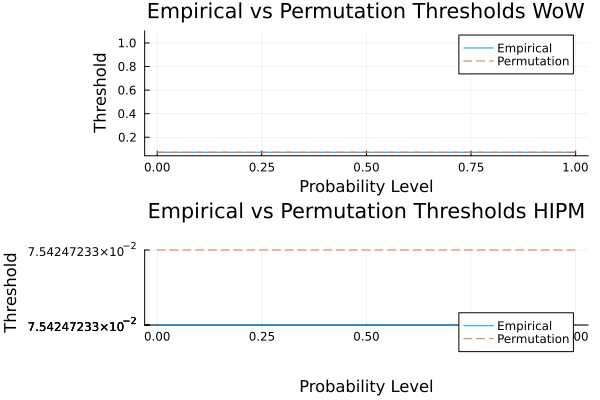

GKS: Possible loss of precision in routine SET_WINDOW


In [13]:
plot(emp_vs_perm_plot[1], emp_vs_perm_plot[2],layout = (2,1))

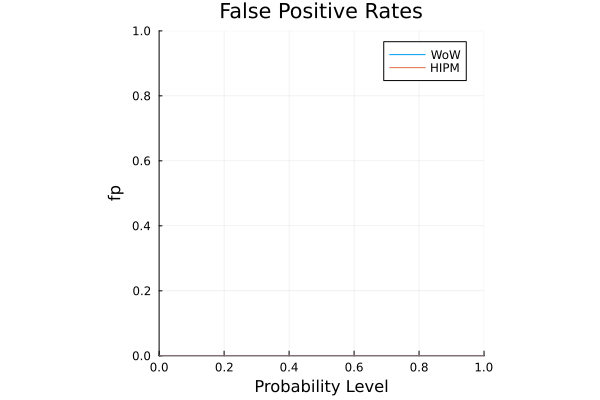

In [14]:
rate_plot

In [15]:
function savefig_discr_discr(n_1::Int, n_2::Int, a::Float64, b::Float64, n::Int, m::Int, s::Int, θs::Vector{Float64}, n_permutations::Int, samemeasures::Bool)
    
    
    # n_1 : number of atoms for Q^1 and Q^2. Those atoms are discrete probability measures themselves.   (maybe change notation?????)
    # n_2 : number of atoms for each of the discrete probability measure that are atoms of laws of RPM. It is same accross all atoms of Q^1 and Q^2.     (maybe change notation?????)
    # those inner probability measures are on [a,b]


    # n :: Number of rows in hierarchical sample
    # m :: Number of columns in hierarchical sample
    # s :: Number of distances sampled
    # θs :: Vector of probability levels for thresholds
    # n_permutations :: Number of permutations for permutation approach

    # samemeasures :: Boolean indicating whether to use same measures for both Q^1 and Q^2

    if samemeasures
        q_discr_1 = discrrpm(n_1,n_2,a,b) 
        q_discr_2 = q_discr_1
    else
        q_discr_1 = discrrpm(n_1,n_2,a,b) 
        q_discr_2 = discrrpm(n_1,n_2,a,b)
    end

    d_wws, d_lips, perm_thresholds, rej_rates, emp_vs_perm_plot, rate_plot = simulate_perm(q_discr_1, q_discr_2, n, m, s, θs, n_permutations, samemeasures)

    filepath = joinpath(pwd(), "newplots/discr_discr")
    emp_perm = plot(emp_vs_perm_plot[1], emp_vs_perm_plot[2],layout = (2,1))
    savefig(emp_perm, joinpath(filepath, "empirical_vs_permutation_discr_discr_n1=$(n_1)_n2=$(n_2)_n=$(n)_m=$(m)_s=$(s)_permutations=$(n_permutations)_samemeasures=$(samemeasures).png"))
    savefig(rate_plot, joinpath(filepath, "rejection_rates_discr_discr_n1=$(n_1)_n2=$(n_2)_n=$(n)_m=$(m)_s=$(s)_permutations=$(n_permutations)_samemeasures=$(samemeasures).png"))
end

savefig_discr_discr (generic function with 1 method)

In [ ]:
# Simulations for Discr_discr

n_1 = 10
n_2 = 2
a, b = 0.0, 1.0
n = 40
m = 2
s = 30
θs = collect(0.0:0.01:1.0)
n_permutations = 30

savefig_discr_discr(n_1, n_2, a, b, n, m, s, θs, n_permutations, false)
savefig_discr_discr(n_1, n_2, a, b, n, m, s, θs, n_permutations, true)





In [ ]:

savefig_discr_discr(n_1, n_2, a, b, n, m, s, θs, n_permutations, false)
savefig_discr_discr(n_1, n_2, a, b, n, m, s, θs, n_permutations, true)

